In [1]:
# Classification Using the MNIST dataset 
%matplotlib inline
import matplotlib as mlp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
# saving figures
def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout() 
    plt.savefig(path, format='png', dpi=300)

In [3]:
# fetching the dataset
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784',version = 1)

In [4]:
mnist.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'DESCR', 'details', 'categories', 'url'])

In [5]:
#seperating the dataset into data and the labels(target)
X,y = mnist['data'], mnist['target']

In [6]:
# viewing the dataset
X.shape
y.shape

(70000,)

In [7]:
#picked the first value of X to view it.
# note that each image was raveled so we had to reshape it.
some_digit = X[0]
some_digit_image = some_digit.reshape(28,28)

(-0.5, 27.5, 27.5, -0.5)

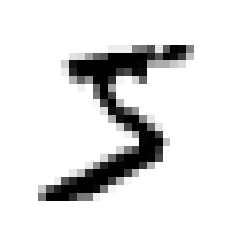

In [8]:
# to display the selected image, we used imshow and not plot.
plt.imshow(some_digit_image,cmap=mlp.cm.binary,interpolation='nearest')
plt.axis('off')

In [9]:
# to display the target value of the selected data i.e X[0]
# note that the returned value is a string
y[0]

'5'

In [10]:
# since  the label(y) is a string we need to convert it to integers
y = y.astype(np.uint8)

# Creating  a test set and a train set

In [11]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# Training a binary classifier

In [12]:
# detecting only the number 5(the 5-detector)
# creating the target vector
y_train_5 = (y_train ==5)
y_test_5 = (y_test == 5)

# StochasticGradientClassifier

In [13]:
#We select the stochastic gradient classifier
from sklearn.linear_model import SGDClassifier

In [14]:
# initialize the classifer
# the random state makes it give a reproducible result
sgd_clf = SGDClassifier(random_state=42)

In [15]:
# fit the training data with all target values == 5
sgd_clf.fit(X_train,y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [16]:
# predict the value of previously selected X[0], returns True if it matches 5
sgd_clf.predict([some_digit])

array([ True])

# Performance measure

Measuring Accuracy using Cross-Validation

Occasionally you will need more control over the cross-validation process than what Scikit-Learn provides off-the-shelf. In these cases, you can implement crossvalidation yourself; it is actually fairly straightforward. The following code does roughly the same thing as Scikit-Learn’s cross_val_score()  function, and prints the same result

In [17]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

In [18]:
# initialize it
skfolds = StratifiedKFold(n_splits = 3, random_state=42)


c:\users\user\appdata\local\programs\python\python37\lib\site-packages\sklearn\model_selection\_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


The  StratifiedKFoldclass performs stratified sampling to produce folds that contain a representative ratio of each class. At each iteration the
code creates a clone of the classifier, trains that clone on the training folds, and makespredictions on the test fold. Then it counts the number of correct predictions andoutputs the ratio of correct predictions.

In [19]:
for train_index , test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds,y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct/ len(y_pred))

0.95035
0.96035
0.9604


# Using cross_val_score

In [20]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf,X_train,y_train,cv=3,scoring ="accuracy")

array([0.87365, 0.85835, 0.8689 ])

# A dump classifier 

In [21]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self,X,y=None):
        pass
    def predict(self,X):
        return np.zeros((len(X),1),dtype=bool)

In [22]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf,X_train,y_train_5,cv=3,scoring='accuracy')


array([0.91125, 0.90855, 0.90915])

That’s right, it has over 90% accuracy! This is simply because only about 10% of the images are 5s, so if you always guess that an image is  nota 5, you will be right about 90% of the time. Beats Nostradamus. This demonstrates why accuracy is generally not the preferred performance measure for classifiers, especially when you are dealing with  skewed datasets  (i.e., when some classes are much more frequent than others).

# Confusion matrix

Just like the  cross_val_score()  function,  cross_val_predict()performs K-fold cross-validation, but instead of returning the evaluation scores, it returns the predictions made on each test fold. This means that you get a clean prediction for each instance in the training set (“clean” meaning that the prediction is made by a model that never saw the data during training).

In [23]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [24]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

Each row in a confusion matrix represents an  actual class, while each column represents a  predicted class. The first row of this matrix considers non-5 images (the  negative class): 53,892 of them were correctly classified as non-5s (they are called  true negatives), while the remaining 687 were wrongly classified as 5s (false positives).The second row considers the images of 5s (the  positive class): 1,891 were wrongly
classified as non-5s (false negatives), while the remaining 3,530 were correctly classified as 5s (true positives). A perfect classifier would have only true positives and truenegatives, so its confusion matrix would have nonzero values only on its main diagonal (top left to bottom right)

In [25]:
y_train_perfect_predictions = y_train_5  # pretend we reached perfection
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

# Precision of classifiers

precision = TP/(TP+FP)

# Recal,Sensitivity or true positive rate(TPR)

recall = TP/(TP+FN)

# Precision and recall score

In [26]:
from sklearn.metrics import precision_score , recall_score

In [27]:
precision_score(y_train_5,y_train_pred)

0.8370879772350012

In [28]:
recall_score(y_train_5,y_train_pred)

0.6511713705958311

It is often convenient to combine precision and recall into a single metric called the F1 score, in particular if you need a simple way to compare two classifiers. The F1 score is the harmonic mean  of precision and recall. Whereas the regular mean treats all values equally, the harmonic mean gives much more weight to low values.As a result, the classifier will only get a high F1 score if both recall and precision are high.

F1 = 2/((1/precision) + (1/recall))

F1 = 2 ×(precision × recall)/(precision + recall)
F1 = TP/(TP+(FN+FP/2))

In [29]:
# compute the F1 score
from sklearn.metrics import f1_score

In [30]:
f1_score(y_train_5,y_train_pred)

0.7325171197343846

Scikit-Learn does not let you set the threshold directly, but it does give you access tothe decision scores that it uses to make predictions. Instead of calling the classifier’spredict()method, you can call its  decision_function()method, which returns ascore for each instance, and then make predictions based on those scores using any threshold you want:

In [31]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [32]:
threshold = 8000

In [33]:
y_some_digit_pred = (y_scores > threshold)

In [34]:
y_some_digit_pred

array([False])

This confirms that raising the threshold decreases recall. The image actually represents a 5, and the classifier detects it when the threshold is 0, but it misses it when the threshold is increased to 8,000. Now how do you decide which threshold to use? For this you will first need to get the
scores of all instances in the training set using the  cross_val_predict()  function again, but this time specifying that you want it to return decision scores instead of predictions

In [35]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3, method ='decision_function')

Now with these scores you can compute precision and recall for all possible thresholds using the precision_recall_curve()function

In [36]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

In [37]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--',label='Precision')
    plt.plot(thresholds,recalls[:-1],'g--', label='Recall')
    plt.legend()
    plt.axis()

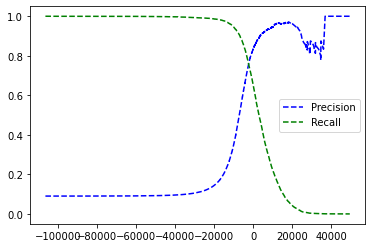

In [38]:
plot_precision_recall_vs_threshold(precisions,recalls,thresholds)
plt.show()

In [39]:
# finding threshold that gives 90% precision
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
y_train_pred_90 = (y_scores >= threshold_90_precision)

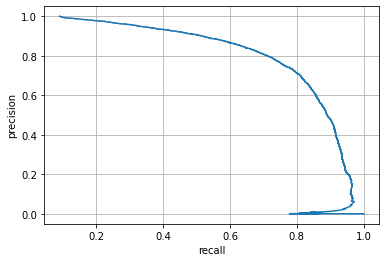

In [40]:
# precision against recall
plt.plot(precisions[:-1],recalls[:-1])
plt.grid()
plt.xlabel('recall')
plt.ylabel('precision')
plt.show()

In [41]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [42]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

# ROC Curve

The  receiver operating characteristic(ROC) curve is another common tool used with binary classifiers. It is very similar to the precision/recall curve, but instead of plotting precision versus recall, the ROC curve plots the  true positive rate(another name for recall) against the false positive rate . The FPR is the ratio of negative instances that are incorrectly classified as positive. It is equal to one minus the  true negative rate, which is the ratio of negative instances that are correctly classified as negative. The TNR is also called  specificity. Hence the ROC curve plots  sensitivity  (recall) versus 1 – specificity.To plot the ROC curve, you first need to compute the TPR and FPR for various threshold values, using the roc_curve()function

In [43]:
from sklearn.metrics import roc_curve
fpr,tpr,thresholds = roc_curve(y_train_5,y_scores)

In [44]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis()
    plt.grid()

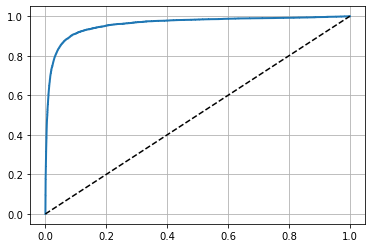

In [45]:
plot_roc_curve(fpr,tpr)

In [46]:
# area under curve
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

# Training a RandomForestClassifier

In [47]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=42)

In [48]:
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,method="predict_proba")

In [49]:
y_scores_forest = y_probas_forest[:, 1]  # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

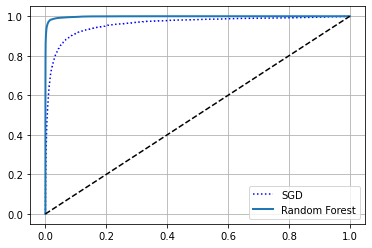

In [50]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

In [51]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

As you can see, the  RandomForestClassifier’s ROC curve looks much
better than the  SGDClassifier’s: it comes much closer to the top-left corner. As a result, its ROC AUC score is also significantly better

# Multiclass Classification

Scikit-Learn detects when you try to use a binary classification algorithm for a multiclass classification task, and it automatically runs OvA (except for SVM classifiers for which it uses OvO). Let’s try this with the SGDClassifier

In [52]:
sgd_clf.fit(X_train, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [53]:
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

That was easy! This code trains the SGDClassifieron the training set using the origi‐
nal target classes from 0 to 9 (y_train), instead of the 5-versus-all target classes
(y_train_5). Then it makes a prediction (a correct one in this case). Under the hood,
Scikit-Learn actually trained 10 binary classifiers, got their decision scores for the
image, and selected the class with the highest score.
To see that this is indeed the case, you can call the  decision_function()  method.
Instead of returning just one score per instance, it now returns 10 scores, one per
class:

In [54]:
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [55]:
np.argmax(some_digit_scores)# returns the index with the highest value

3

In [56]:
sgd_clf.classes_
'''When a classifier is trained, it stores the list of target classes in its
classes_ attribute, ordered by value. In this case, the index of each
class in the  classes_array conveniently matches the class itself
(e.g., the class at index 5 happens to be class 5), but in general you
won’t be so lucky'''

'When a classifier is trained, it stores the list of target classes in its\nclasses_ attribute, ordered by value. In this case, the index of each\nclass in the  classes_array conveniently matches the class itself\n(e.g., the class at index 5 happens to be class 5), but in general you\nwon’t be so lucky'

In [57]:
'''If you want to force ScikitLearn to use one-versus-one or one-versus-all, you can use
the  OneVsOneClassifieror OneVsRestClassifier  classes. Simply create an instance
and pass a binary classifier to its constructor. For example, this code creates a multi‐
class classifier using the OvO strategy, based on a SGDClassifier'''

'If you want to force ScikitLearn to use one-versus-one or one-versus-all, you can use\nthe  OneVsOneClassifieror OneVsRestClassifier  classes. Simply create an instance\nand pass a binary classifier to its constructor. For example, this code creates a multi‐\nclass classifier using the OvO strategy, based on a SGDClassifier'

In [58]:
from sklearn.multiclass import OneVsOneClassifier

In [59]:
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))

In [60]:
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])

array([5], dtype=uint8)

In [61]:
len(ovo_clf.estimators_)

45

# Training a RandomForestClassifier

In [62]:
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

array([5], dtype=uint8)

In [63]:
forest_clf.predict_proba([some_digit])

array([[0.  , 0.  , 0.01, 0.08, 0.  , 0.9 , 0.  , 0.  , 0.  , 0.01]])

Now of course you want to evaluate these classifiers. As usual, you want to use crossvalidation. Let’s evaluate the SGDClassifier’s accuracy using the  cross_val_score()
function.It gets over 84% on all test folds. If you used a random classifier, you would get 10%
accuracy, so this is not such a bad score, but you can still do much better. For exam‐
ple, simply scaling the inputs  increases  accuracy above
89%

In [64]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

# Error Analysis

First, you can look at the confusion matrix. You need to make predictions using the
cross_val_predict()function, then call the confusion_matrix()  function, just like
you did earlier

In [65]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]],
      dtype=int64)

That’s a lot of numbers. It’s often more convenient to look at an image representation
of the confusion matrix, using Matplotlib’s matshow()function

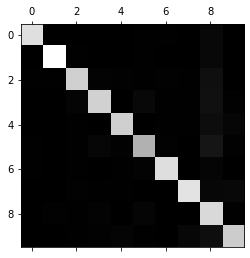

In [66]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

Let’s focus the plot on the errors. First, you need to divide each value in the confusion
matrix by the number of images in the corresponding class, so you can compare error rates instead of absolute number of errors (which would make abundant classes look
unfairly bad)

In [67]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

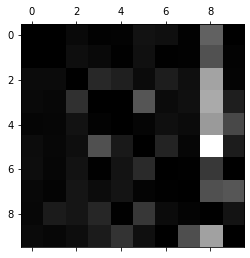

In [68]:
#Now let’s fill the diagonal with zeros to keep only the errors, and let’s plot the result:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

# Multilabel Classification

Until now each instance has always been assigned to just one class. In some cases you
may want your classifier to output multiple classes for each instance. For example,
consider a face-recognition classifier: what should it do if it recognizes several people
on the same picture? Of course it should attach one tag per person it recognizes. Say
the classifier has been trained to recognize three faces, Alice, Bob, and Charlie; then
when it is shown a picture of Alice and Charlie, it should output [1, 0, 1] (meaning
“Alice yes, Bob no, Charlie yes”). Such a classification system that outputs multiple
binary tags is called a multilabel classificationsystem

In [70]:
from sklearn.neighbors import KNeighborsClassifier
y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [71]:
knn_clf.predict([some_digit])

array([[False,  True]])

This code creates a  y_multilabelarray containing two target labels for each digit
image: the first indicates whether or not the digit is large (7, 8, or 9) and the second
indicates whether or not it is odd. The next lines create a  KNeighborsClassifier
instance (which supports multilabel classification, but not all classifiers do) and we
train it using the multiple targets array. Now you can make a prediction, and notice
that it outputs two labels And it gets it right! The digit 5 is indeed not large (False) and odd (True)

There are many ways to evaluate a multilabel classifier, and selecting the right metric
really depends on your project. For example, one approach is to measure the F
1
score
for each individual label (or any other binary classifier metric discussed earlier), then
simply compute the average score. This code computes the average F
1
score across all
labels

In [ ]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

This assumes that all labels are equally important, which may not be the case. In par‐
ticular, if you have many more pictures of Alice than of Bob or Charlie, you may want
to give more weight to the classifier’s score on pictures of Alice. One simple option is
to give each label a weight equal to its  support  (i.e., the number of instances with that
target label). To do this, simply set average="weighted"in the preceding code

# Multioutput Classification

To illustrate this, let’s build a system that removes noise from images. It will take as
input a noisy digit image, and it will (hopefully) output a clean digit image, repre‐
sented as an array of pixel intensities, just like the MNIST images. Notice that the
classifier’s output is multilabel (one label per pixel) and each label can have multiple
values (pixel intensity ranges from 0 to 255). It is thus an example of a multioutput
classification system

In [ ]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

In [ ]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit) 

# Saving models

In [1]:
from sklearn.externals import joblib
joblib.dump(knn_clf,'myKNClassifier') 


SyntaxError: invalid syntax (<ipython-input-1-33f90f3712ea>, line 1)